# Extracting track sections from coordinates

We want to split a race track into sections, based on the coordinates of the track.
A track can be considered of a series of corners and straights. 
A corner can be connected to another corner, or to a straight. 
See [driver61.com](https://driver61.com/uni/different-corner-technique/) explanation for more details.

The track features to be extracted are:
* the sequence of corners and straights
* the start and end of a sequence in meters on the track
  * the start of a corner is when the track starts to curve
  * the end of a corner is when the track starts to straighten out
* the curvature of a straight. Some straights are not completely straight, but have a slight curve.


Let's look at the Nürburgring track:
<br/>
 <img src="https://static.wikia.nocookie.net/f1wikia/images/b/b0/Nurburgring2002.png/revision/latest?cb=20130301114136" style="width: 50%;"/> 

The sequence would be:
1. straight "Start und Zielgerade"
2. corner "1"
3. corner "Mercedes Arena"
4. corner "3"
5. corner "4"
6. straight
7. corner "5"
8. corner "Ford Kurve"
9. straight
10. corner "Dunlop Kehre"
11. straight
12. corner "Michael Schumacher S"
13. corner 9
14. straight
15. corner "RTL Kurve"
16. straight
17. corner "Warsteiner Kurve"
18. straight
19. corner "ADVAN Bogen"
20. straight
21. corner "13"
22. corner "NGK Schikane"
23. corner "Coca-Cola Kurve"


Notice that a straight, like number 9, which connects "Ford-Kurve" and "Dunlop Kehre", might not be completely straight, but have a slight curve.


## source data

The data is stored in an InfluxDB database. It's collected from sim racing games. The game submits the telemetry data at a sample frequency of 60 Hz.
The coordinates are in the world coordinate system, which is different depending on the game. The coordinates are not in meters, but in some game specific unit. The coordinates are the position of the car in the world during a lap.
The start and end of a lap data is not 100% connected, since the car does not cross the the start and finish line at the very same coordinates.
The field `DistanceOnTrack` is the car position in meters on the track. This field will be used to add a length to each track section.

## data preparation

1. collect coordinates for multiple laps on a given track per game
   * since we record data from different cars and different drivers, we want to use many samples to get a statistically significant result.
2. map the coordinates to a universal coordinate system, which is the same for all games
   * every game uses slightly different units and x,y,z coordinates. To make the next steps universal, we need to normalize the data to a universal coordinate system. The coordinates can differ in scale and projection (like being mirrored)
3. remove outliers from laps
   * out of all the collected laps, calculate a single, well connected line, that is the best fit to the actual track. Some drivers have a different racing line on the track, or even spin the car during a lap.
4. split laps into sections, based on the data of all recorded laps
   * the extracted features are:
      * the sequence of corners and straights
      * every sequences has a start and end in meters
      * the end of sequence n is the start of sequence n+1


# Data exploration

The following is a data exploration of the data. It only shows 3 laps from 2 different games for 2 different tracks.
The data for the Nürburgring track shows 2 laps with car spins on the track to visualize the need for removing outliers and normalizing the data for a given track.
The data for Spa shows, that the coordinate system can be mirrored for a given game.

The actual data will be provided as SessionId and LapId combinations, for a set of tracks and games.
Per track the number of laps varies from 1 to 15. Total it will be approx 4 games with approx 10 tracks per game.


In [272]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull

import influxdb_client
from IPython.display import Image

from influxdb_client.client.write_api import SYNCHRONOUS

import warnings
from influxdb_client.client.warnings import MissingPivotFunction

warnings.simplefilter("ignore", MissingPivotFunction)

# configure influxdb client
ORG = "b4mad"
TOKEN = os.environ.get(
    "INFLUXDB_TOKEN",
    "citqAMr66LLb25hvaaZm2LezOc88k2ocOFJcJDR6QB-RmLJa_-sAr9kYB4vSFYaz8bt26lm7SokVgpQKdgKFKA==",
)
URL = "https://telemetry.b4mad.racing/"

client = influxdb_client.InfluxDBClient(url=URL, token=TOKEN, org=ORG)
query_api = client.query_api()
pd.set_option("display.max_columns", None)

In [273]:
# a function to query the database for a given session and lap
def query_session_lap(session, lap):
    query = f"""
    from(bucket: "racing")
    |> range(start: -10y, stop: now())
    |> filter(fn: (r) => r["_measurement"] == "laps_cc")
    |> filter(fn: (r) => r["SessionId"] == "{session}")
    |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> filter(fn: (r) => r["CurrentLap"] == "{lap}")
    |> sort(columns: ["_time"], desc: false)
    """
    return query_api.query_data_frame(org=ORG, query=query)

In [274]:
tracks = {
    "Nurburgring_2020:Nurb_GP_2020_Veedol-1": {
        "game": "Automobilista 2",
        "session": 1670584820,
        "lap": 1,
        "image": "https://static.wikia.nocookie.net/f1wikia/images/b/b0/Nurburgring2002.png/revision/latest?cb=20130301114136",
    },
    "Nurburgring_2020:Nurb_GP_2020_Veedol-2": {
        "game": "Automobilista 2",
        "session": 1670584820,
        "lap": 2,
        "image": "https://static.wikia.nocookie.net/f1wikia/images/b/b0/Nurburgring2002.png/revision/latest?cb=20130301114136",
    },
    "Nurburgring_2020:Nurb_GP_2020_Veedol-3": {
        "game": "Automobilista 2",
        "session": 1670584820,
        "lap": 3,
        "image": "https://static.wikia.nocookie.net/f1wikia/images/b/b0/Nurburgring2002.png/revision/latest?cb=20130301114136",
    },
    "Spa:track config": {
        "game": "Assetto Corsa Competizione",
        "session": 1670586823,
        "lap": 8,
        "image": "https://static.wikia.nocookie.net/f1wikia/images/3/3f/Track_map_of_Spa-Francorchamps_in_Belgium.svg/revision/latest/scale-to-width-down/1000?cb=20120730120932",
    },
}

for track, data in tracks.items():
    tracks[track]["df"] = query_session_lap(data["session"], data["lap"])

'Nurburgring_2020:Nurb_GP_2020_Veedol-1'

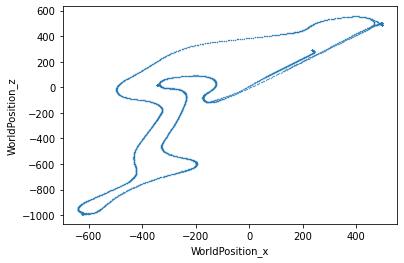

,result,table,_start,_stop,_time,CarModel,CurrentLap,GameName,SessionId,SessionTypeName,TrackCode,_measurement,host,topic,user,Brake,Clutch,CurrentLapIsValid,CurrentLapTime,DistanceRoundTrack,Gear,Handbrake,LapTimePrevious,PreviousLapWasValid,Rpms,SpeedMs,SteeringAngle,Throttle,WorldPosition_x,WorldPosition_y,WorldPosition_z
0,_result,0,2012-12-16 05:49:07.125315+00:00,2022-12-16 17:49:07.125315+00:00,2022-12-09 12:20:20.626369+00:00,Porsche 911 RSR GTE,1,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,1.0,0.0,False,-3.000000,0.000,0.0,0.0,-1.0,True,0.000,0.00000,0.000000,0.0,235.758377,-6.537385,290.169400
3045,_result,0,2012-12-16 05:49:07.125315+00:00,2022-12-16 17:49:07.125315+00:00,2022-12-09 12:25:28.085268+00:00,Porsche 911 RSR GTE,1,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,0.0,0.0,True,138.926086,5123.455,5.0,0.0,-1.0,False,8127.544,62.82423,0.000763,1.0,129.348300,-7.737313,131.231552


'Nurburgring_2020:Nurb_GP_2020_Veedol-2'

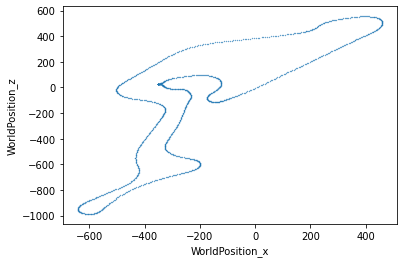

,result,table,_start,_stop,_time,CarModel,CurrentLap,GameName,SessionId,SessionTypeName,TrackCode,_measurement,host,topic,user,Brake,Clutch,CurrentLapIsValid,CurrentLapTime,DistanceRoundTrack,Gear,Handbrake,LapTimePrevious,PreviousLapWasValid,Rpms,SpeedMs,SteeringAngle,Throttle,WorldPosition_x,WorldPosition_y,WorldPosition_z
0,_result,0,2012-12-16 05:49:11.323016+00:00,2022-12-16 17:49:11.323016+00:00,2022-12-09 12:25:28.196479+00:00,Porsche 911 RSR GTE,2,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,0.0,0.0,True,98.339294,4.459284,5.0,0.0,140.66626,True,8151.83057,63.058765,0.000611,1.0,125.050995,-7.807137,126.633125
1217,_result,0,2012-12-16 05:49:11.323016+00:00,2022-12-16 17:49:11.323016+00:00,2022-12-09 12:27:31.084774+00:00,Porsche 911 RSR GTE,2,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,0.0,0.0,True,103.855469,5123.926000,5.0,0.0,140.66626,True,8420.78100,65.099970,0.000305,1.0,130.214264,-7.705030,129.749466


'Nurburgring_2020:Nurb_GP_2020_Veedol-3'

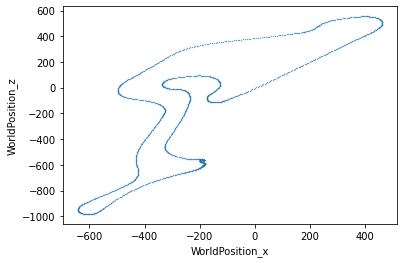

,result,table,_start,_stop,_time,CarModel,CurrentLap,GameName,SessionId,SessionTypeName,TrackCode,_measurement,host,topic,user,Brake,Clutch,CurrentLapIsValid,CurrentLapTime,DistanceRoundTrack,Gear,Handbrake,LapTimePrevious,PreviousLapWasValid,Rpms,SpeedMs,SteeringAngle,Throttle,WorldPosition_x,WorldPosition_y,WorldPosition_z
0,_result,0,2012-12-16 05:49:13.626746+00:00,2022-12-16 17:49:13.626746+00:00,2022-12-09 12:27:31.193622+00:00,Porsche 911 RSR GTE,3,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,0.0,0.0,True,62.794130,6.14080,5.0,0.0,122.977844,True,8443.941,65.342804,0.000000,1.0,125.009926,-7.795475,124.348717
1358,_result,0,2012-12-16 05:49:13.626746+00:00,2022-12-16 17:49:13.626746+00:00,2022-12-09 12:29:48.316888+00:00,Porsche 911 RSR GTE,3,Automobilista 2,1670584820,Practice,Nurburgring_2020:Nurb_GP_2020_Veedol,laps_cc,telegraf,crewchief/goern/1670584820/Automobilista 2/Nur...,goern,0.0,0.0,True,97.201904,5123.20068,5.0,0.0,122.977844,True,8457.679,65.405280,-0.000153,1.0,130.531418,-7.702488,130.450226


'Spa:track config'

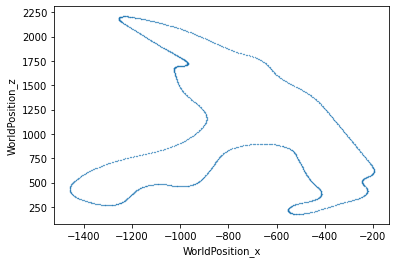

,result,table,_start,_stop,_time,CarModel,CurrentLap,GameName,SessionId,SessionTypeName,TrackCode,_measurement,host,topic,user,Brake,Clutch,CurrentLapTime,DistanceRoundTrack,Gear,Handbrake,Rpms,SpeedMs,SteeringAngle,Throttle,WorldPosition_x,WorldPosition_y,WorldPosition_z
0,_result,0,2012-12-16 05:49:15.990271+00:00,2022-12-16 17:49:15.990271+00:00,2022-12-09 13:10:01.655171+00:00,Unknown,8,Assetto Corsa Competizione,1670586823,Race,Spa:track config,laps_cc,telegraf,crewchief/Jim/1670586823/Assetto Corsa Competi...,Jim,0.0,1.0,0.797,6.324125,4.0,0.0,5678.0,48.082325,0.0,1.0,-1082.61400,0.0,1903.51800
1274,_result,0,2012-12-16 05:49:15.990271+00:00,2022-12-16 17:49:15.990271+00:00,2022-12-09 13:12:21.624334+00:00,Unknown,8,Assetto Corsa Competizione,1670586823,Race,Spa:track config,laps_cc,telegraf,crewchief/Jim/1670586823/Assetto Corsa Competi...,Jim,0.0,1.0,0.520,7001.245610,4.0,0.0,5610.0,47.448100,0.0,1.0,-1078.21667,0.0,1895.76257


In [275]:
# iterate over all tracks
for track, data in tracks.items():
    df = data["df"]
    display(track)
    # scatter plot with a point size of 0.1
    if data["game"] == "Automobilista 2":
        df.plot.scatter(x="WorldPosition_x", y="WorldPosition_z", s=0.1)
    if data["game"] == "Assetto Corsa Competizione":
        # flip y axis
        df["WorldPosition_z"] = df["WorldPosition_z"] * -1
        df.plot.scatter(x="WorldPosition_x", y="WorldPosition_z", s=0.1)
    plt.show()
    display(Image(url=data["image"], width=800, unconfined=True))
    # display the first and last row of the dataframe
    display(pd.concat([df.head(1), df.tail(1)]))

## Preprocessing data

1. Some dataframes contains multiple laps. These multiple laps need to be split single laps.
2. In some laps vehicle goes out the track and driver goes revers. Driving reverse parts can be cleaned from data.

### 1. Split the laps

It can be seen below, a single dataframe passes start point twice

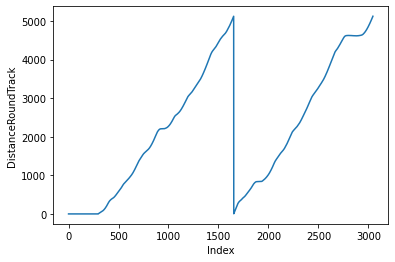

In [276]:
# Convert df data to numpy arrays
df = tracks["Nurburgring_2020:Nurb_GP_2020_Veedol-1"]["df"]
distances = df[['DistanceRoundTrack']].to_numpy()[:,0]
points = df[['WorldPosition_x','WorldPosition_z']].to_numpy()

plt.plot(distances)
plt.xlabel('Index')
plt.ylabel('DistanceRoundTrack')
plt.show()

When car passes start point, distance drops significantly. This information can be used to split laps

In [277]:
# This function split data for multiple laps
def split_laps(distances, points, threshold=100):
    laps = []
    prev_idx = 0
    for idx in range(1, distances.shape[0]):
        # If DistanceRoundTrack dropped significantly, this is a new lap
        passed_start = distances[idx] - distances[idx-1] < -threshold
        last_point = (idx == distances.shape[0]-1)
        if passed_start or last_point:
            lap_distances = distances[prev_idx:idx]
            lap_points = points[prev_idx:idx]
            lap = {'distances': lap_distances,
                   'points': lap_points}
            laps.append(lap)
            prev_idx = idx
    return laps

In [278]:
tracks_ = {'track_1': {'laps': []},
           'track_2': {'laps': []}}
# iterate over all tracks
threshold = 100
for track, data in tracks.items():
    df = data["df"]
    # Split data to multiple laps
    if data["game"] == "Automobilista 2":
        distances = df[['DistanceRoundTrack']].to_numpy()[:,0]
        points = df[['WorldPosition_x','WorldPosition_z']].to_numpy()
        laps = split_laps(distances, points)
        tracks_['track_1']['laps'].extend(laps)
        
    if data["game"] == "Assetto Corsa Competizione":
        # flip y axis
        df["WorldPosition_z"] = df["WorldPosition_z"] * -1
        distances = df[['DistanceRoundTrack']].to_numpy()[:,0]
        points = df[['WorldPosition_x','WorldPosition_z']].to_numpy()
        laps = split_laps(distances, points)
        tracks_['track_2']['laps'].extend(laps)

tracks = tracks_


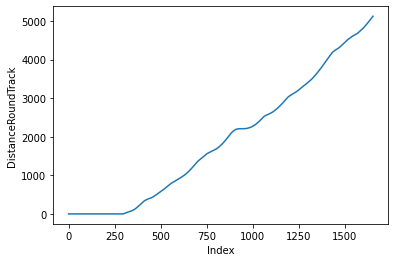

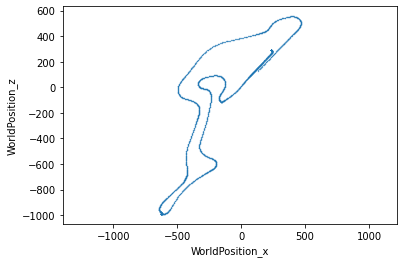

In [279]:
# Plotting split lap result
distances = tracks['track_1']['laps'][0]['distances']
points = tracks['track_1']['laps'][0]['points']

plt.figure()
plt.plot(distances)
plt.xlabel('Index')
plt.ylabel('DistanceRoundTrack')

plt.figure()
x = points[:,0]
y = points[:,1]
plt.scatter(x, y, s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()

### 2. Drop telemetry messages where DistanceRoundTrack is not increasing

DistanceRoundTrack value is not increasing in following conditions:
  * Car is driving reverse
  * Car is outside the track

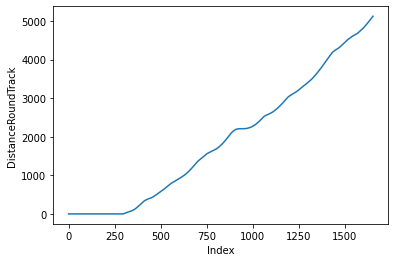

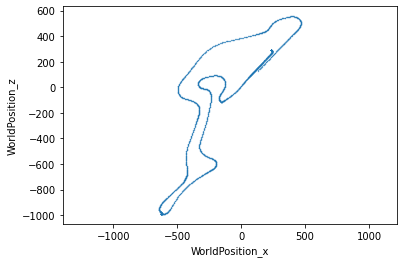

In [280]:
distances = tracks['track_1']['laps'][0]['distances']
points = tracks['track_1']['laps'][0]['points']
plt.figure()
plt.plot(distances)
plt.xlabel('Index')
plt.ylabel('DistanceRoundTrack')

plt.figure()
x = points[:,0]
y = points[:,1]
plt.scatter(x, y, s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()

These telemetry message are not need for calculations and they can be dropped.

In [281]:
# Iterate over the tracks
for track_id in tracks.keys():
    laps = tracks[track_id]['laps']
    # Iterate over the laps
    for lap_idx in range(len(laps)):
        distances = laps[lap_idx]['distances'].copy()
        points = laps[lap_idx]['points'].copy()
        max_distance = distances[0]
        selected_idx = []
        for idx in range(distances.shape[0]):
            # If distance is higher than previous distance, select the point
            if distances[idx] > max_distance:
                selected_idx.append(idx)
                max_distance = distances[idx]
        # Select distance increasing points
        tracks[track_id]['laps'][lap_idx]['distances'] = distances[selected_idx]
        tracks[track_id]['laps'][lap_idx]['points'] = points[selected_idx]

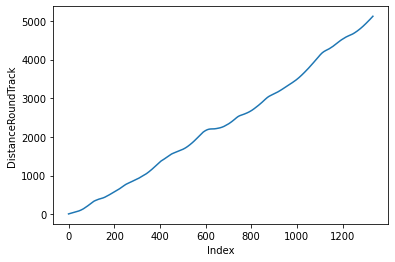

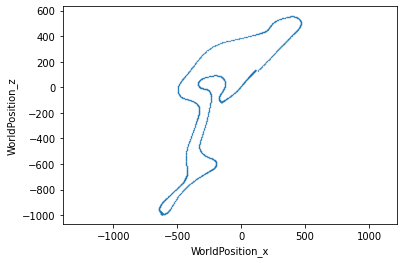

In [282]:
distances = tracks['track_1']['laps'][0]['distances']
points = tracks['track_1']['laps'][0]['points']

plt.figure()
plt.plot(distances)
plt.xlabel('Index')
plt.ylabel('DistanceRoundTrack')

plt.figure()
x = points[:,0]
y = points[:,1]
plt.scatter(x, y, s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()

### 3. Calculate track length

Track lenght is not available in the data. It can be calculated by

In [283]:
for track_id in tracks.keys():
    laps = tracks[track_id]['laps']
    lenght = 0
    for lap_idx in range(len(laps)):
        max_distance = laps[lap_idx]['distances'].max()
        if max_distance > lenght:
            lenght = max_distance
    tracks[track_id]['length'] = lenght

In [284]:
for track_id in tracks.keys():
    print(track_id, 'length..:', tracks[track_id]['length'])

track_1 length..: 5123.275
track_2 length..: 7001.24561


### 4. Resample laps

Telemetry data is recorded based on time. When vehicle is driving slow, gets more sample from same position. These position need to be resampled

In [285]:
delta_distance = 0.001 * 1863.8057506844502
# Iterate over the tracks
for track_id in tracks.keys(): 
    laps = tracks[track_id]['laps']
    lenght = tracks[track_id]['length']
    # Iterate over the laps 
    for lap_idx in range(len(laps)):
        distances = laps[lap_idx]['distances'].copy()
        points = laps[lap_idx]['points'].copy()
        resampled_distances = np.arange(0, lenght, delta_distance)
        x = points[:,0]
        y = points[:,1]
        x_n = np.interp(resampled_distances, distances, x, left=np.nan, right=np.nan)
        y_n = np.interp(resampled_distances, distances, y, left=np.nan, right=np.nan)  
        
        tracks[track_id]['laps'][lap_idx]['distances'] = resampled_distances
        tracks[track_id]['laps'][lap_idx]['points'] = np.column_stack((x_n, y_n))

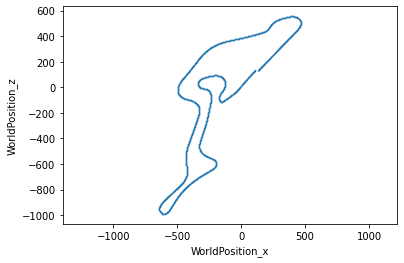

In [286]:
distances = tracks['track_1']['laps'][0]['distances']
points = tracks['track_1']['laps'][0]['points']

plt.figure()
x = points[:,0]
y = points[:,1]
plt.scatter(x, y, s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()

### 5. Fill with nan around outliers

Laps have some extream telemetry message. These outliers need to be filled with nan values

In [287]:
delta_distance = 0.001 * 1863.8057506844502
threshold = 0.4 #[radian]
nan_range = 60

nan_range_index = nan_range / delta_distance
for track_id in tracks.keys(): 
    laps = tracks[track_id]['laps']
    lenght = tracks[track_id]['length']
    # Iterate over the laps 
    for lap_idx in range(len(laps)):
        distances = laps[lap_idx]['distances'].copy()
        points = laps[lap_idx]['points'].copy()

        differences = np.diff(points, axis=0)
        yaw_angles = np.arctan2(differences[:,0], differences[:,1])
        mask = ~np.isnan(yaw_angles)
        yaw_angles[mask] = np.unwrap(yaw_angles[mask])
        yaw_changes = np.diff(yaw_angles)
        for point_idx in range(points.shape[0]-2):
            if abs(yaw_changes[point_idx]) > threshold:
                start = int(max(0, point_idx-nan_range_index))
                end = int(min(points.shape[0]-1, point_idx+nan_range_index))
                points[start:end,:] = np.nan
        tracks[track_id]['laps'][lap_idx]['points'] = points



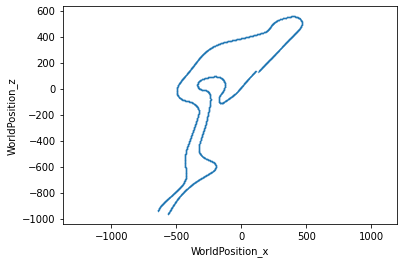

In [293]:
distances = tracks['track_1']['laps'][0]['distances']
points = tracks['track_1']['laps'][0]['points']

plt.figure()
x = points[:,0]
y = points[:,1]
plt.scatter(x, y, s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()

### 6. Calculate track points and yaw change

In [294]:
filter_range = 20
# Iterate over the tracks
for track_id in tracks.keys(): 
    laps = tracks[track_id]['laps']
    lenght = tracks[track_id]['length']
    resampled_distances = np.arange(0, lenght, delta_distance)
    
    distances = []
    points = []
    yaw_changes = []
    for dist in range(resampled_distances.shape[0]):
        total_dd = []
        total_xx = []
        total_yy = []
        # Iterate over the laps 
        for lap_idx in range(len(laps)):
            f_distances = np.arange(dist-filter_range, dist+filter_range, delta_distance)
            dd = laps[lap_idx]['distances']
            xx = laps[lap_idx]['points'][:,0]
            yy = laps[lap_idx]['points'][:,1]
            x = np.interp(f_distances, dd, xx, left=np.nan, right=np.nan)
            y = np.interp(f_distances, dd, yy, left=np.nan, right=np.nan)
        
        if f_distances[~np.isnan(x)].shape[0] > 0:
            total_dd.append(f_distances[~np.isnan(x)])
            total_xx.append(x[~np.isnan(x)])
            total_yy.append(y[~np.isnan(x)])

            total_dd = np.concatenate(total_dd, axis=0)
            total_xx = np.concatenate(total_xx, axis=0)
            total_yy = np.concatenate(total_yy, axis=0)

            px = np.polyfit(total_dd, total_xx, 3)
            py = np.polyfit(total_dd, total_yy, 3)
            fx = np.poly1d(px)
            fy = np.poly1d(py)

            poin = np.array([fx(dist), fy(dist)])
            poiiiii.append(poin)
            ddddd.append(dist)
    poiiiii = np.array(poiiiii)
    tracks[track_id]['distances'] = np.array(ddddd)[1:]
    tracks[track_id]['points'] = np.array(poiiiii)[1:]
    differences = np.diff(poiiiii, axis=0)
    yaw_angles = np.arctan2(differences[:,0], differences[:,1])
    yaw_angles = np.unwrap(yaw_angles)
    tracks[track_id]['yaw_angles'] = yaw_angles

NameError: name 'poiiiii' is not defined

In [ ]:
distances = tracks['track_1']['distances']
points = tracks['track_1']['points']
yaw_angles = tracks['track_1']['yaw_angles']

plt.figure()
plt.plot(distances, yaw_angles, '.-')
plt.xlabel('DistanceRoundTrack')
plt.ylabel('YawAngle')
plt.show()

plt.figure()
x = points[:,0]
y = points[:,1]
plt.scatter(x, y, s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.show()

In [ ]:
for track_id in tracks.keys():
    distances = tracks[track_id]['distances']
    points = tracks[track_id]['points']
    yaw_angles = tracks[track_id]['yaw_angles']
    yaw_rates = np.diff(yaw_angles)

    print(distances.shape)
    print(points.shape)
    print(yaw_angles.shape)

    tracks[track_id]['distances'] = distances[1:]
    tracks[track_id]['points'] = points[1:,:]
    tracks[track_id]['yaw_angles'] = yaw_angles[1:]
    tracks[track_id]['yaw_rates'] = yaw_rates[1:]

plt.plot(tracks['track_1']['yaw_rates'])
plt.show()


(274,)
(274, 2)
(274,)
(360,)
(360, 2)
(360,)


In [ ]:
yaw_rate_threshold = 0.035


yaw_rates = tracks['track_1']['yaw_rates']
points = tracks['track_1']['points']


left = np.where(yaw_rates>yaw_rate_threshold)[0]
right = np.where(yaw_rates<-yaw_rate_threshold)[0]

x = points[:,0]
y = points[:,1]
plt.scatter(x, y, s=0.1)
x = points[left,0]
y = points[left,1]
plt.scatter(x, y, s=40)
x = points[right,0]
y = points[right,1]
plt.scatter(x, y, s=40)
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.gca().set_aspect('equal', 'datalim')
plt.show()

In [ ]:


yaw_rates = tracks['track_2']['yaw_rates']
points = tracks['track_2']['points']


left = np.where(yaw_rates>yaw_rate_threshold)[0]
right = np.where(yaw_rates<-yaw_rate_threshold)[0]

x = points[:,0]
y = points[:,1]
plt.scatter(x, y, s=0.1)
x = points[left,0]
y = points[left,1]
plt.scatter(x, y, s=40)
x = points[right,0]
y = points[right,1]
plt.scatter(x, y, s=40)
plt.xlabel('WorldPosition_x')
plt.ylabel('WorldPosition_z')
plt.gca().set_aspect('equal', 'datalim')

plt.show()